# 13.4b: Embedding Evolution Analysis

**Did dead tokens move during training?**

We have the complete training trajectory from 13.4a (1,001 snapshots). Let's analyze:

1. **Did dead tokens change at all?**
2. **When did they freeze?**
3. **What was their trajectory before freezing?**
4. **How do live tokens behave differently?**

## Parameters

In [1]:
# Data
DATA_PATH = "../data/embeddings_gatsby_f32_sigma1e-05/embedding_evolution.safetensors"

# Analysis
CHANGE_THRESHOLD = 1e-10  # Threshold for "changed" vs "stayed the same"

# Visualization
DPI = 100
COLORMAP = 'inferno'

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [3]:
print(f"Loading: {DATA_PATH}")

data = load_file(DATA_PATH)

embedding_history = data['embedding_history'].float()  # [1001, 128, 64]
dead_token_ids = data['dead_token_ids'].tolist()
init_sigma = data['init_sigma'].item()

n_steps, vocab_size, hidden_dim = embedding_history.shape

print(f"\n  Shape: {embedding_history.shape}")
print(f"  Steps: {n_steps - 1} (+ initial state)")
print(f"  Vocab: {vocab_size}")
print(f"  Hidden dim: {hidden_dim}")
print(f"  Dead tokens: {len(dead_token_ids)} / {vocab_size}")
print(f"  Init σ: {init_sigma:.2e}")
print(f"\n✓ Data loaded")

Loading: ../data/embeddings_gatsby_f32_sigma1e-05/embedding_evolution.safetensors

  Shape: torch.Size([1001, 128, 64])
  Steps: 1000 (+ initial state)
  Vocab: 128
  Hidden dim: 64
  Dead tokens: 51 / 128
  Init σ: 1.00e-05

✓ Data loaded


## Extract Dead vs Live Tokens

In [4]:
# Dead token trajectories: [n_steps, n_dead, hidden_dim]
dead_embeddings = embedding_history[:, dead_token_ids, :]

# Live token IDs
all_token_ids = set(range(vocab_size))
live_token_ids = sorted(all_token_ids - set(dead_token_ids))

# Sample a few live tokens for comparison
np.random.seed(RANDOM_SEED)
sample_live_ids = sorted(np.random.choice(live_token_ids, size=min(10, len(live_token_ids)), replace=False).tolist())

live_embeddings_sample = embedding_history[:, sample_live_ids, :]

print(f"Dead tokens: {dead_embeddings.shape[1]}")
print(f"Live tokens (total): {len(live_token_ids)}")
print(f"Live tokens (sample): {len(sample_live_ids)}")
print(f"\nSample live token IDs: {sample_live_ids}")
print(f"\n✓ Tokens extracted")

Dead tokens: 51
Live tokens (total): 77
Live tokens (sample): 10

Sample live token IDs: [10, 40, 48, 70, 77, 87, 89, 93, 99, 112]

✓ Tokens extracted


## Question 1: Did Dead Tokens Move At All?

In [5]:
print(f"\n{'='*80}")
print(f"QUESTION 1: DID DEAD TOKENS MOVE?")
print(f"{'='*80}\n")

# For each dead token, compute max change over entire training
initial_dead = dead_embeddings[0]  # [n_dead, hidden_dim]

max_changes = []

for t in range(1, n_steps):
    delta = torch.abs(dead_embeddings[t] - initial_dead)
    max_change_per_token = delta.max(dim=1)[0]  # L∞ per token
    max_changes.append(max_change_per_token)

max_changes = torch.stack(max_changes)  # [n_steps-1, n_dead]

# Overall max change per token
overall_max_per_token = max_changes.max(dim=0)[0]

n_moved = (overall_max_per_token > CHANGE_THRESHOLD).sum().item()
n_frozen = (overall_max_per_token <= CHANGE_THRESHOLD).sum().item()

print(f"Threshold for 'moved': {CHANGE_THRESHOLD:.2e}\n")
print(f"Dead tokens that MOVED: {n_moved} / {len(dead_token_ids)} ({100 * n_moved / len(dead_token_ids):.1f}%)")
print(f"Dead tokens that stayed FROZEN: {n_frozen} / {len(dead_token_ids)} ({100 * n_frozen / len(dead_token_ids):.1f}%)")

if n_moved > 0:
    print(f"\nMax change (across all dead tokens, all steps): {overall_max_per_token.max().item():.6e}")
    print(f"Mean max change: {overall_max_per_token.mean().item():.6e}")
    print(f"Median max change: {overall_max_per_token.median().item():.6e}")
else:
    print(f"\n✓ ALL DEAD TOKENS FROZEN (no movement detected)")


QUESTION 1: DID DEAD TOKENS MOVE?

Threshold for 'moved': 1.00e-10

Dead tokens that MOVED: 51 / 51 (100.0%)
Dead tokens that stayed FROZEN: 0 / 51 (0.0%)

Max change (across all dead tokens, all steps): 1.846085e-01
Mean max change: 1.840499e-01
Median max change: 1.836243e-01


## Question 2: When Did They Freeze?


QUESTION 2: WHEN DID THEY FREEZE?

Earliest freeze: step 1000
Latest freeze: step 1000
Mean freeze step: 1000.0
Median freeze step: 1000.0


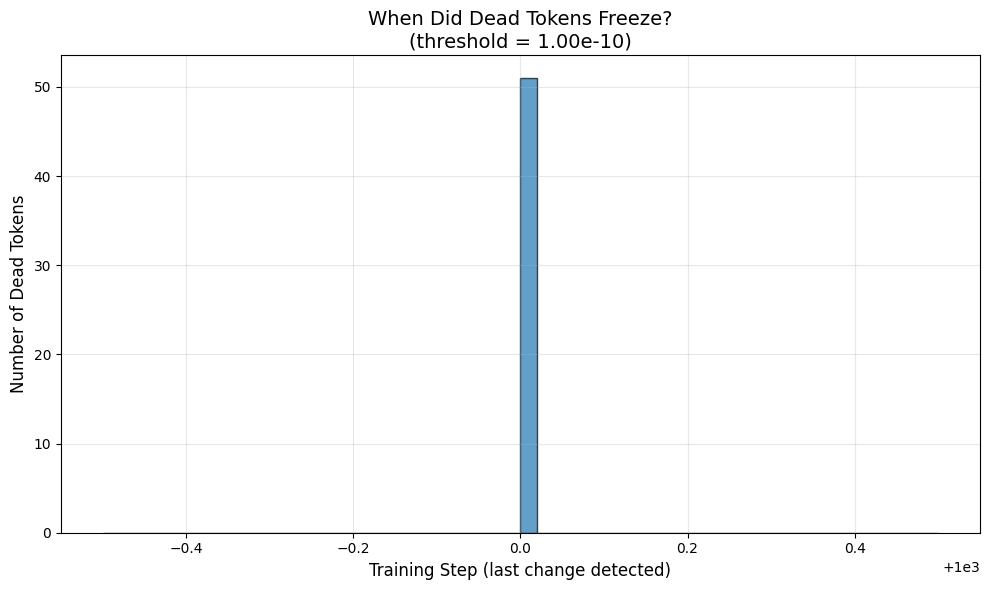


✓ Freeze time analysis complete


In [6]:
print(f"\n{'='*80}")
print(f"QUESTION 2: WHEN DID THEY FREEZE?")
print(f"{'='*80}\n")

if n_moved == 0:
    print("All dead tokens were frozen from the start (step 0).")
else:
    # For each dead token, find the LAST step where it changed
    freeze_steps = []
    
    for token_idx in range(len(dead_token_ids)):
        # Find last step with change > threshold
        changes = max_changes[:, token_idx]
        changed_steps = torch.where(changes > CHANGE_THRESHOLD)[0]
        
        if len(changed_steps) > 0:
            last_change = changed_steps[-1].item() + 1  # +1 because max_changes starts at step 1
        else:
            last_change = 0  # Never moved
        
        freeze_steps.append(last_change)
    
    freeze_steps = np.array(freeze_steps)
    
    print(f"Earliest freeze: step {freeze_steps.min()}")
    print(f"Latest freeze: step {freeze_steps.max()}")
    print(f"Mean freeze step: {freeze_steps.mean():.1f}")
    print(f"Median freeze step: {np.median(freeze_steps):.1f}")
    
    # Histogram of freeze times
    fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)
    
    ax.hist(freeze_steps, bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Training Step (last change detected)', fontsize=12)
    ax.set_ylabel('Number of Dead Tokens', fontsize=12)
    ax.set_title(f'When Did Dead Tokens Freeze?\n(threshold = {CHANGE_THRESHOLD:.2e})', fontsize=14)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Freeze time analysis complete")

## Question 3: What Was the Trajectory Before Freezing?


QUESTION 3: TRAJECTORY BEFORE FREEZING



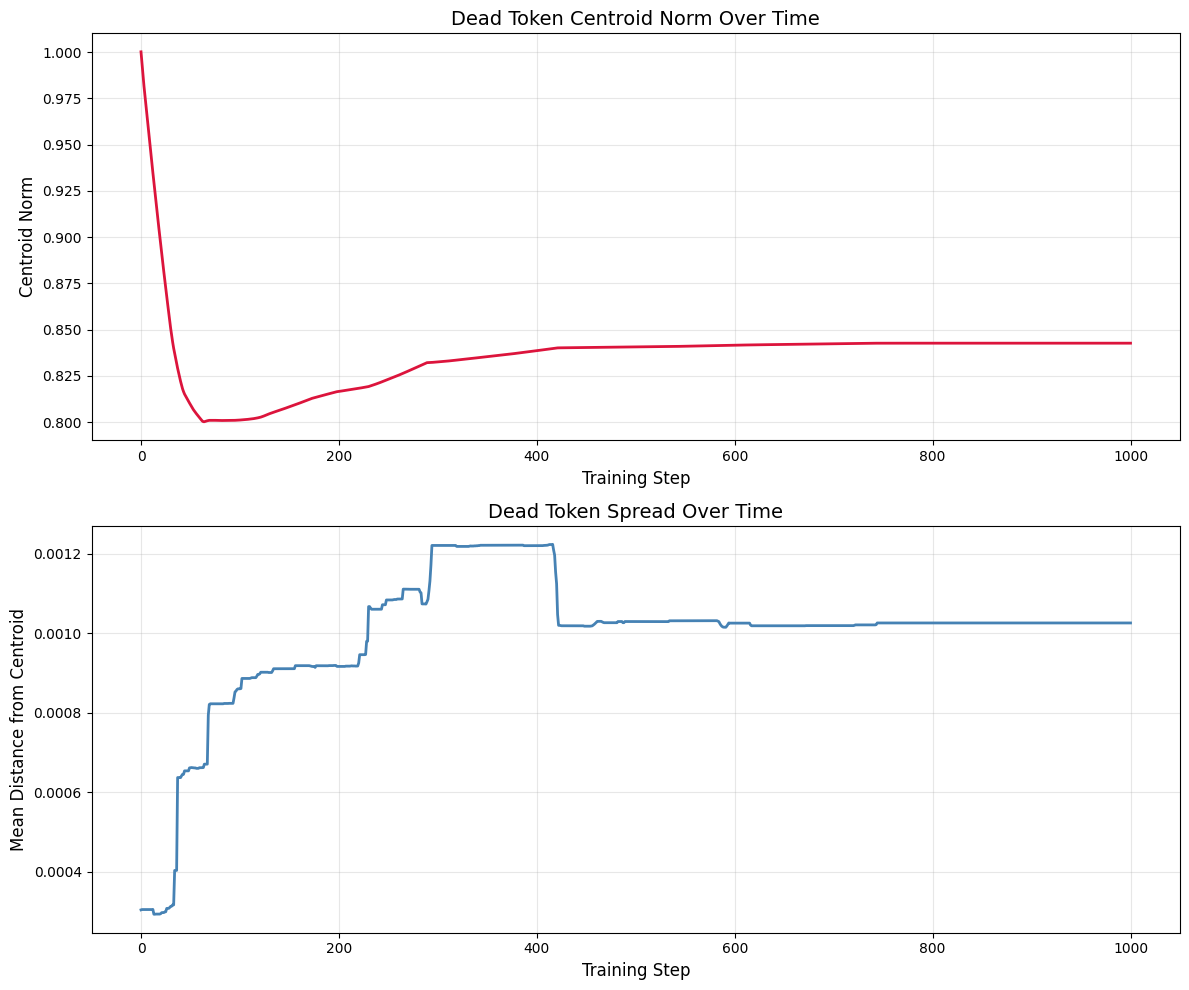

Initial centroid norm: 1.000156
Final centroid norm: 0.842696
Centroid drift: -1.574608e-01

Initial spread: 3.035075e-04
Final spread: 1.025524e-03
Spread change: 7.220170e-04

✓ Trajectory analysis complete


In [7]:
print(f"\n{'='*80}")
print(f"QUESTION 3: TRAJECTORY BEFORE FREEZING")
print(f"{'='*80}\n")

if n_moved == 0:
    print("No trajectory to analyze (tokens never moved).")
else:
    # Compute centroid of dead tokens over time
    dead_centroids = dead_embeddings.mean(dim=1)  # [n_steps, hidden_dim]
    centroid_norms = torch.norm(dead_centroids, p=2, dim=1)
    
    # Compute mean distance from centroid over time
    distances_from_centroid = []
    for t in range(n_steps):
        diffs = dead_embeddings[t] - dead_centroids[t]
        dists = torch.norm(diffs, p=2, dim=1)
        distances_from_centroid.append(dists.mean().item())
    
    distances_from_centroid = np.array(distances_from_centroid)
    
    # Plot trajectory
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), dpi=DPI)
    
    # Panel 1: Centroid norm over time
    axes[0].plot(range(n_steps), centroid_norms.numpy(), linewidth=2, color='crimson')
    axes[0].set_xlabel('Training Step', fontsize=12)
    axes[0].set_ylabel('Centroid Norm', fontsize=12)
    axes[0].set_title('Dead Token Centroid Norm Over Time', fontsize=14)
    axes[0].grid(alpha=0.3)
    
    # Panel 2: Mean distance from centroid
    axes[1].plot(range(n_steps), distances_from_centroid, linewidth=2, color='steelblue')
    axes[1].set_xlabel('Training Step', fontsize=12)
    axes[1].set_ylabel('Mean Distance from Centroid', fontsize=12)
    axes[1].set_title('Dead Token Spread Over Time', fontsize=14)
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Initial centroid norm: {centroid_norms[0].item():.6f}")
    print(f"Final centroid norm: {centroid_norms[-1].item():.6f}")
    print(f"Centroid drift: {(centroid_norms[-1] - centroid_norms[0]).item():.6e}")
    
    print(f"\nInitial spread: {distances_from_centroid[0]:.6e}")
    print(f"Final spread: {distances_from_centroid[-1]:.6e}")
    print(f"Spread change: {(distances_from_centroid[-1] - distances_from_centroid[0]):.6e}")
    
    print(f"\n✓ Trajectory analysis complete")

## Question 4: Live Token Behavior (Comparison)


QUESTION 4: LIVE TOKEN BEHAVIOR



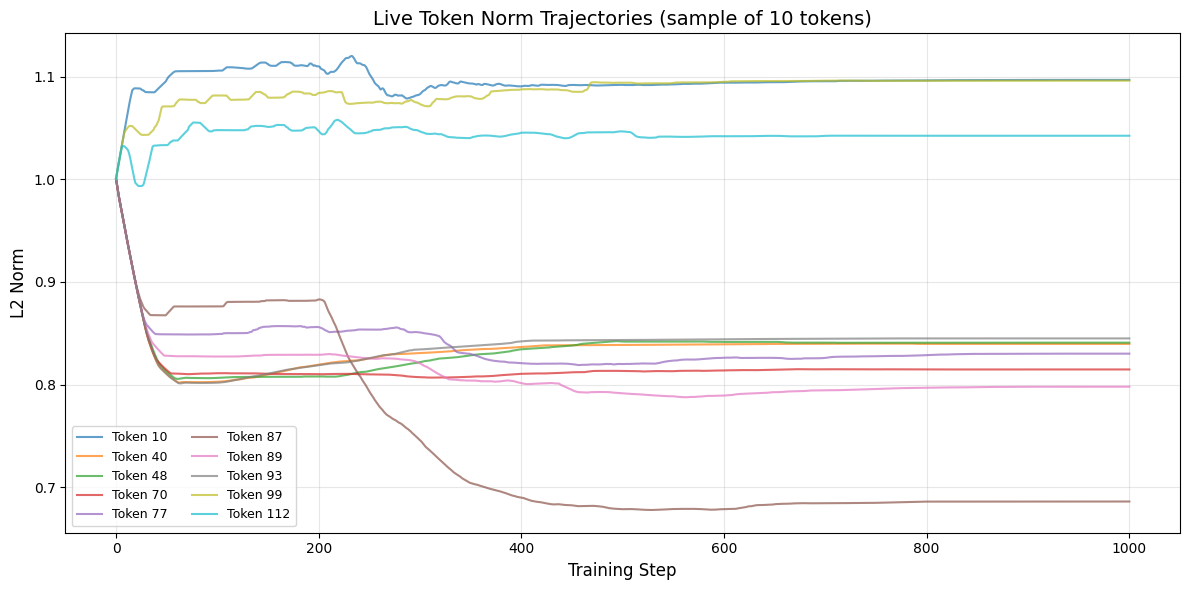

Initial live token norms: 1.000128 to 1.000182
Final live token norms: 0.686206 to 1.096682
Mean change: -0.111200

✓ Live token analysis complete


In [8]:
print(f"\n{'='*80}")
print(f"QUESTION 4: LIVE TOKEN BEHAVIOR")
print(f"{'='*80}\n")

# Compute L2 norm over time for sample live tokens
live_norms = torch.norm(live_embeddings_sample, p=2, dim=2)  # [n_steps, n_sample]

# Plot trajectories
fig, ax = plt.subplots(figsize=(12, 6), dpi=DPI)

for i, token_id in enumerate(sample_live_ids):
    ax.plot(range(n_steps), live_norms[:, i].numpy(), linewidth=1.5, alpha=0.7, label=f'Token {token_id}')

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('L2 Norm', fontsize=12)
ax.set_title(f'Live Token Norm Trajectories (sample of {len(sample_live_ids)} tokens)', fontsize=14)
ax.legend(loc='best', fontsize=9, ncol=2)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Stats
initial_live_norms = live_norms[0].numpy()
final_live_norms = live_norms[-1].numpy()

print(f"Initial live token norms: {initial_live_norms.min():.6f} to {initial_live_norms.max():.6f}")
print(f"Final live token norms: {final_live_norms.min():.6f} to {final_live_norms.max():.6f}")
print(f"Mean change: {(final_live_norms - initial_live_norms).mean():.6f}")

print(f"\n✓ Live token analysis complete")

## Summary

**Key Questions:**
1. Did dead tokens move? → (see output above)
2. When did they freeze? → (see histogram)
3. What was their trajectory? → (see centroid/spread plots)
4. How do live tokens differ? → (see norm trajectories)

**Interpretation:**
- If dead tokens never moved → frozen from initialization, no training dynamics
- If dead tokens moved then froze → training dynamics affect them initially, then gradients go to zero
- Live tokens should show continuous evolution throughout training